In [1]:
%cd ..

d:\github\ripple_heterogeneity\python


In [2]:
import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt

import hdf5storage
import h5py
import scipy.io as sio

import sys,os

import functions,loading

import nelpy as nel  # main nelpy imports
import nelpy.plotting as npl  # optional plotting import

import math

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [95]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "svg.fonttype": 'none'
}
plt.style.use('seaborn-paper')
plt.rcParams.update(tex_fonts)

# plt.rcParams['svg.fonttype'] = 'none'

%config InlineBackend.figure_format = 'retina'

fig_save_path = 'G:/My Drive/post_doc/ripple_diversity/project_log'

In [96]:
# sessions = glob.glob(r'D:\projects\ripple_heterogeneity\swr_seq_isi_deep_sup\*.csv')
sessions = glob.glob(r'D:\projects\ripple_heterogeneity\swr_seq_isi_deep_sup\*.csv')

df = pd.read_csv(sessions[1])

In [121]:
sessions[1]

'D:\\projects\\ripple_heterogeneity\\swr_seq_isi_deep_sup\\AB3_AB3_38_41.csv'

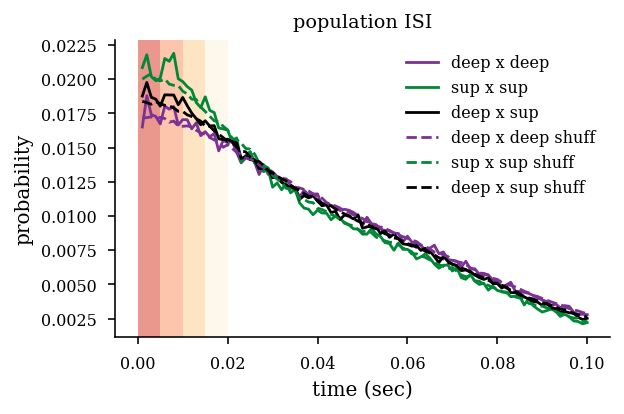

In [120]:
def bin_data(data,xmin=0,xmax=0.100,binwidth=0.001):
    bins = np.arange(xmin,xmax+binwidth,binwidth)

    hist, _ = np.histogram(data,bins=bins)
    hist = hist/hist.sum()
    return hist

bin_center = np.arange(0,0.100,0.001) + 0.001

plt.figure(figsize=functions.set_size('thesis', fraction=.75, subplots=(1, 1)), edgecolor='k')
plt.plot(bin_center,bin_data(df.Deep),color="#7b3294",label="deep x deep")
plt.plot(bin_center,bin_data(df.Superficial),color="#008837",label="sup x sup") 
plt.plot(bin_center,bin_data(df.DeepSuperficial),color="black",label="deep x sup") 

ripple_cycle = 1/200
plt.axvspan(0,ripple_cycle, color='#d7301f', alpha=0.5, lw=0)
plt.axvspan(ripple_cycle,ripple_cycle*2, color='#fc8d59', alpha=0.5, lw=0)
plt.axvspan(ripple_cycle*2,ripple_cycle*3, color='#fdcc8a', alpha=0.5, lw=0)
plt.axvspan(ripple_cycle*3,ripple_cycle*4, color='#fef0d9', alpha=0.5, lw=0)


plt.plot(bin_center,bin_data(df.Deep_shuff),linestyle="--",color="#7b3294",label="deep x deep shuff")
plt.plot(bin_center,bin_data(df.Superficial_shuff),linestyle="--",color="#008837",label="sup x sup shuff") 
plt.plot(bin_center,bin_data(df.DeepSuperficial_shuff),linestyle="--",color="black",label="deep x sup shuff") 

plt.xlabel('time (sec)')
plt.ylabel('probability')
plt.title('population ISI')

# plt.xscale("log")

plt.legend(frameon=False)

ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# plt.figure(figsize=(10,5))

# b1,b2 = np.polyfit(np.log(bin_center), bin_data(df.Deep), 1)
# plt.plot(bin_center,b1*np.log(bin_center) + b2,label="fit") 
 
# b1,b2 = np.polyfit(np.log(bin_center), bin_data(df.Superficial), 1)
# plt.plot(bin_center,b1*np.log(bin_center) + b2,label="fit") 

# b1,b2 = np.polyfit(np.log(bin_center), bin_data(df.DeepSuperficial), 1)
# plt.plot(bin_center,b1*np.log(bin_center) + b2,label="fit") 

plt.savefig(os.path.join(fig_save_path,'swr_seq_isi_example.pdf'),dpi=300,bbox_inches='tight')
plt.savefig(os.path.join(fig_save_path,'swr_seq_isi_example.png'),dpi=300,bbox_inches='tight')


In [122]:
df.Deep


0          0.02510
1          0.05335
2          0.08215
3          0.08760
4          0.09210
            ...   
8104315        NaN
8104316        NaN
8104317        NaN
8104318        NaN
8104319        NaN
Name: Deep, Length: 8104320, dtype: float64

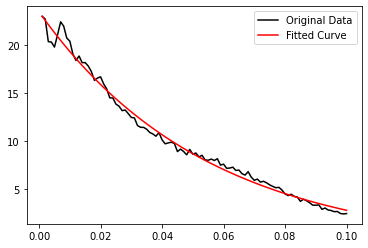

In [71]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, pcov = curve_fit(func, bin_center, bin_data(df.DeepSuperficial))

plt.figure()
plt.plot(bin_center, bin_data(df.DeepSuperficial), 'k', label="Original Data")
plt.plot(bin_center, func(bin_center, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()